# Alpha Factor Evaluation

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_market_calendars as mcal
from alphalens.utils import get_clean_factor_and_forward_returns


from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [14]:
HDF_PATH = Path('..', '00_data', 'assets.h5')
TRADING_DAYS = 21
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5

## Load Data

### Get Performance Data

In [8]:
performance = pd.read_pickle('results/mean_reversal.pickle')

In [9]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
algo_volatility            754 non-null float64
algorithm_period_return    755 non-null float64
alpha                      754 non-null float64
benchmark_period_return    755 non-null float64
benchmark_volatility       754 non-null float64
beta                       754 non-null float64
capital_used               755 non-null float64
ending_cash                755 non-null float64
ending_exposure            755 non-null float64
ending_value               755 non-null float64
excess_return              755 non-null float64
factor_data                755 non-null object
gross_leverage             755 non-null float64
long_exposure              755 non-null float64
long_value                 755 non-null float64
longs_count                755 non-null int64
max_drawdown               755 non-null float64
max_leverage               755 no

### Get Prices

In [10]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Columns: 1661 entries, A to ZTS
dtypes: float64(1661)
memory usage: 9.6 MB


### Get Factor Data

In [11]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2015-01-02 00:00:00+00:00  A        2618.0
                           AAL      1088.0
                           AAP       791.0
                           AAPL     2917.0
                           ABBV     2952.0
dtype: float64

### Sector Data

In [15]:
assets = prices.columns
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')[['sector']].dropna()
    df = df[~df.index.duplicated()]
df = df.loc[assets].fillna('Unknown')

In [16]:
ids, names = pd.factorize(df.sector)
sectors = pd.Series(ids, index=df.index).to_dict()
sector_names = {i: n for i, n in enumerate(names)}

## Compute AlphaLens Data

In [ ]:
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES,
                                                      groupby=sectors,
                                                      groupby_labels=sector_names)
dates = alphalens_data.index.get_level_values('date').unique()
alphalens_data.info()

In [67]:
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)
dates = alphalens_data.index.get_level_values('date').unique()
alphalens_data.info()

Dropped 14.5% entries from factor data: 14.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 642938 entries, (2015-01-02 00:00:00+00:00, A) to (2017-10-30 00:00:00+00:00, ZTS)
Data columns (total 6 columns):
5D                 642938 non-null float64
10D                642938 non-null float64
21D                642938 non-null float64
42D                642938 non-null float64
factor             642938 non-null float64
factor_quantile    642938 non-null int64
dtypes: float64(5), int64(1)
memory usage: 31.9+ MB


In [69]:
alphalens_data.head().to_csv('factor_data.csv')

While looking at quantiles is important we must also look at the factor returns as a whole. The cumulative factor long/short returns plot lets us view the combined effects overtime of our entire factor.

## Get Benchmark

In [19]:
def get_sp500_fw(start=2010, end=2017):
    with pd.HDFStore(HDF_PATH) as store:
        sp500 = store['sp500/prices'].close.loc[str(start):str(end)]
    sp500 = sp500.resample('D').ffill().tz_localize('utc')
    df = pd.concat([(sp500
                     .pct_change(periods=fw)
                     .shift(-fw)
                     .squeeze()
                     .to_frame(f'{fw}D')) for fw in HOLDING_PERIODS], axis=1)
    return df.dropna()

In [20]:
def get_benchmark(factor_data, start=2013):
    factor_dates = factor_data.index.get_level_values('date').unique()
    last = (factor_dates.max() + BDay(max(HOLDING_PERIODS))).year + 1
    sp500 = get_sp500_fw(start=start, end=last)
    return sp500.filter(dates, axis=0)

In [21]:
benchmark = get_benchmark(alphalens_data)
benchmark.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713 entries, 2015-01-02 to 2017-10-30
Data columns (total 4 columns):
5D     713 non-null float64
10D    713 non-null float64
21D    713 non-null float64
42D    713 non-null float64
dtypes: float64(4)
memory usage: 27.9 KB


## Summary Tear Sheet

Quantiles Statistics


min     max         mean         std   count    count %
factor_quantile                                                            
1                   1.0  1115.0   301.980136  187.992483  128875  20.044701
2                 337.0  1782.0   843.855418  241.218338  128446  19.977976
3                 743.0  2306.0  1400.251818  271.991154  128446  19.977976
4                1204.0  2719.0  1962.969941  263.516180  128446  19.977976
5                1760.0  3056.0  2508.149715  231.925464  128725  20.021371

Returns Analysis


5D     10D    21D    42D
Ann. alpha                                      0.026   0.024  0.006 -0.002
beta                                            0.075   0.070  0.065  0.028
Mean Period Wise Return Top Quantile (bps)      4.137   5.096  2.525 -0.958
Mean Period Wise Return Bottom Quantile (bps) -10.003  -7.856 -2.894 -1.346
Mean Period Wise Spread (bps)                  14.029  12.872  5.359  0.319

Information Analysis


5D    10D    21D    42D
IC Mean           0.014  0.017  0.012  0.001
IC Std.           0.140  0.132  0.123  0.123
Risk-Adjusted IC  0.100  0.132  0.095  0.005
t-stat(IC)        2.678  3.527  2.529  0.144
p-value(IC)       0.008  0.000  0.012  0.886
IC Skew           0.411  0.224  0.192  0.209
IC Kurtosis       0.182 -0.330 -0.423 -0.265

Turnover Analysis


10D    21D    42D     5D
Quantile 1 Mean Turnover   0.588  0.832  0.828  0.410
Quantile 2 Mean Turnover   0.741  0.801  0.810  0.646
Quantile 3 Mean Turnover   0.762  0.804  0.807  0.681
Quantile 4 Mean Turnover   0.739  0.806  0.808  0.642
Quantile 5 Mean Turnover   0.568  0.811  0.806  0.394

5D    10D    21D    42D
Mean Factor Rank Autocorrelation  0.711  0.452 -0.031 -0.013

<Figure size 432x288 with 0 Axes>

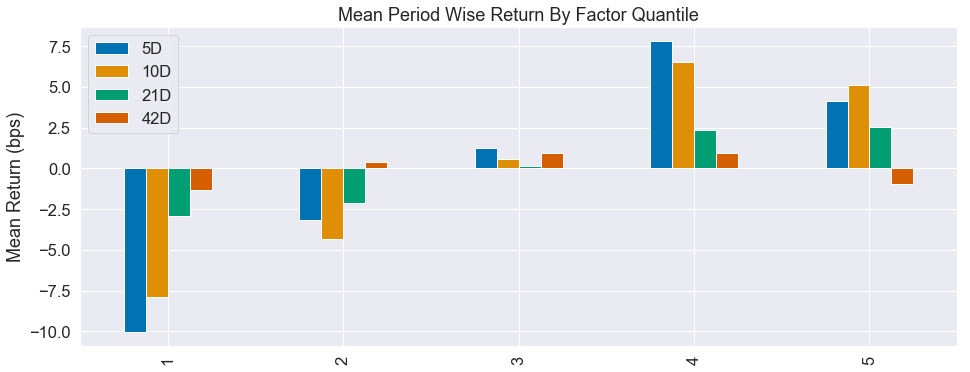

In [22]:
create_summary_tear_sheet(factor_data=alphalens_data)

## Returns Analysis

Returns analysis gives us a raw description of a factor's value that shows us the power of a factor in real currency values.

### Mean Return by Factor Quantile

One of the most basic ways to look at a factor's predicitve power is to look at the mean return of different factor quantile. 

#### Total Return by Factor Quantile

In [23]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

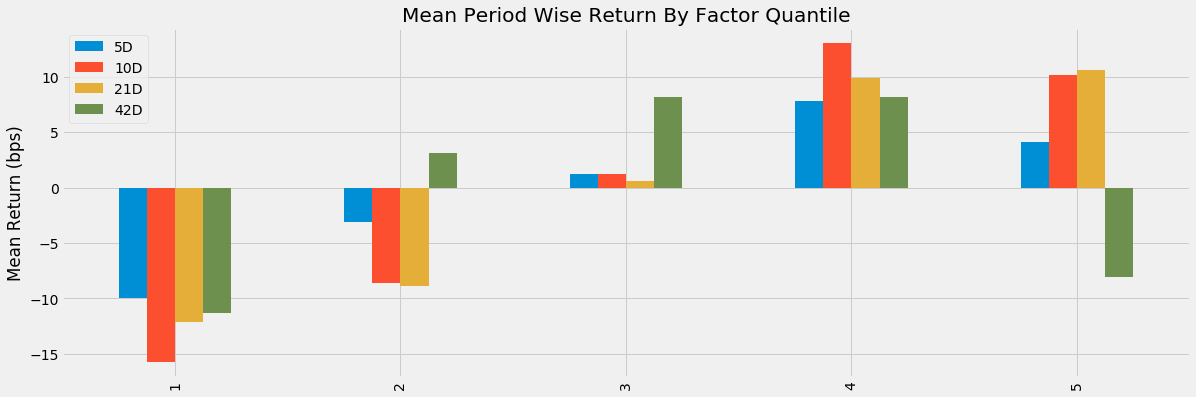

In [70]:
plot_quantile_returns_bar(mean_return_by_q);

#### Normalized return by quintile

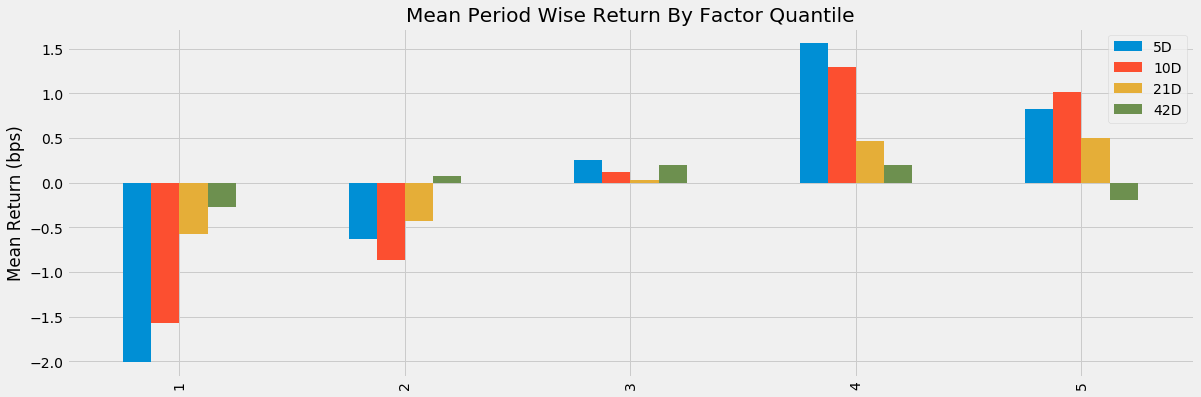

In [24]:
plot_quantile_returns_bar(mean_return_by_q_norm);

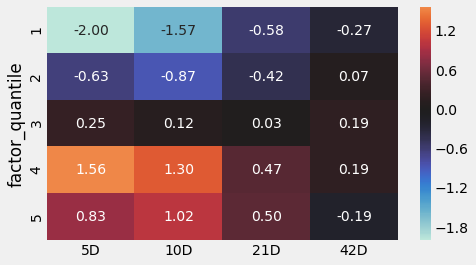

In [25]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(mean_return_by_q_norm.mul(10000), center=0, ax=ax, annot=True, fmt='.2f');

#### Daily Return by Factor Quantile

In [26]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

In [27]:
mean_return_by_q_daily.head()

5D       10D       21D  \
factor_quantile date                                                      
1               2015-01-02 00:00:00+00:00 -0.005365 -0.011881 -0.006969   
                2015-01-05 00:00:00+00:00 -0.001748  0.001151  0.002873   
                2015-01-06 00:00:00+00:00  0.003286  0.004854  0.005133   
                2015-01-07 00:00:00+00:00  0.012046  0.005904 -0.001234   
                2015-01-08 00:00:00+00:00  0.015326  0.014486  0.009751   

                                                42D  
factor_quantile date                                 
1               2015-01-02 00:00:00+00:00 -0.016610  
                2015-01-05 00:00:00+00:00 -0.018150  
                2015-01-06 00:00:00+00:00 -0.013848  
                2015-01-07 00:00:00+00:00 -0.018191  
                2015-01-08 00:00:00+00:00 -0.008329

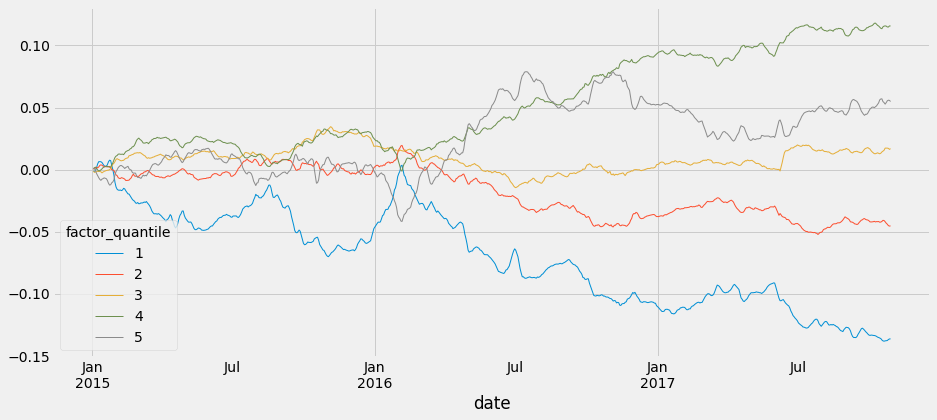

In [66]:
daily_returns = mean_return_by_q_daily['5D'].unstack('factor_quantile')
daily_returns.add(1).pow(1/5).cumprod().sub(1).plot(lw=1, figsize=(14, 6));

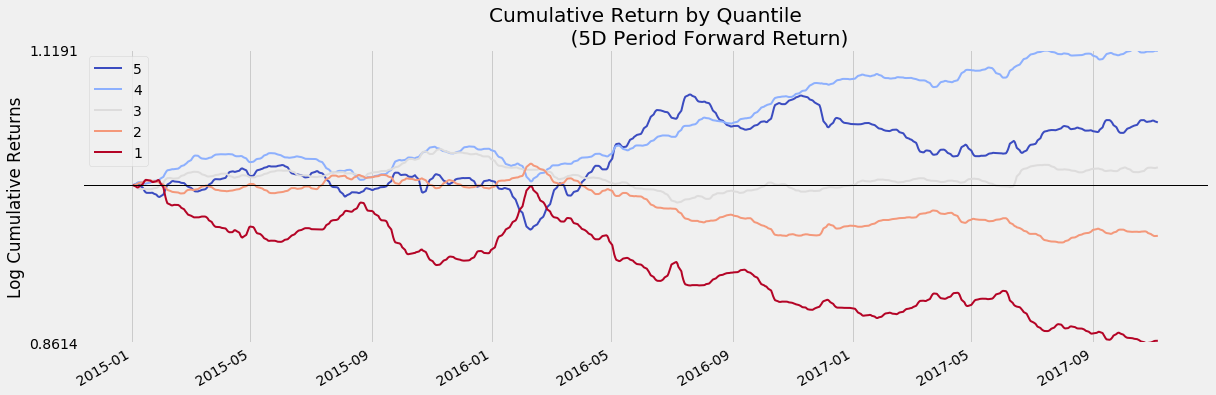

In [29]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D');

By looking at the mean return by quantile we can get a real look at how well the factor differentiates forward returns across the signal values. Obviously we want securities with a better signal to exhibit higher returns. For a good factor we'd expect to see negative values in the lower quartiles and positive values in the upper quantiles.

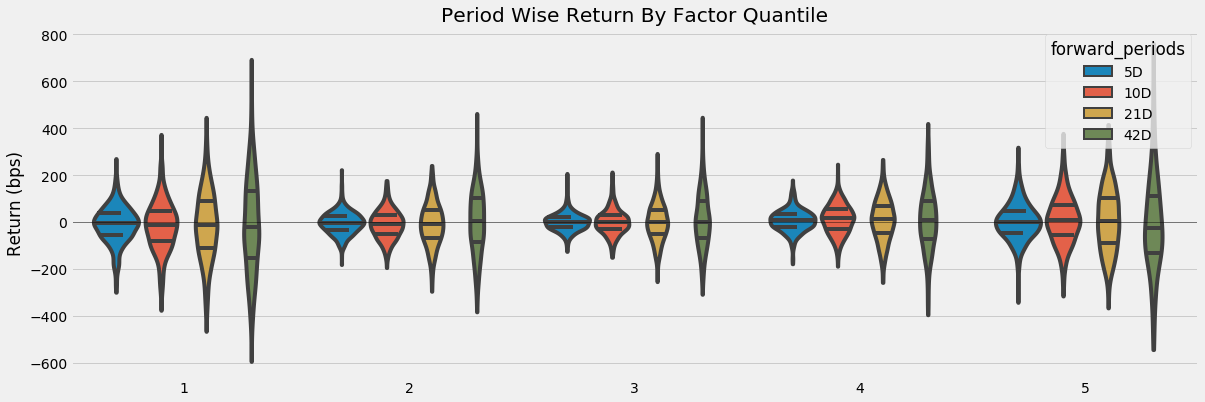

In [30]:
plot_quantile_returns_violin(mean_return_by_q_daily);

This violin plot is similar to the one before it but shows more information about the underlying data. It gives a better idea about the range of values, the median, and the inter-quartile range. What gives the plots their shape is the application of a probability density of the data at different values.

In [31]:
quant_return_spread, std_err_spread = compute_mean_returns_spread(mean_return_by_q_daily,
                                                                  lower_quant=1,
                                                                  upper_quant=5,
                                                                  std_err=std_err)

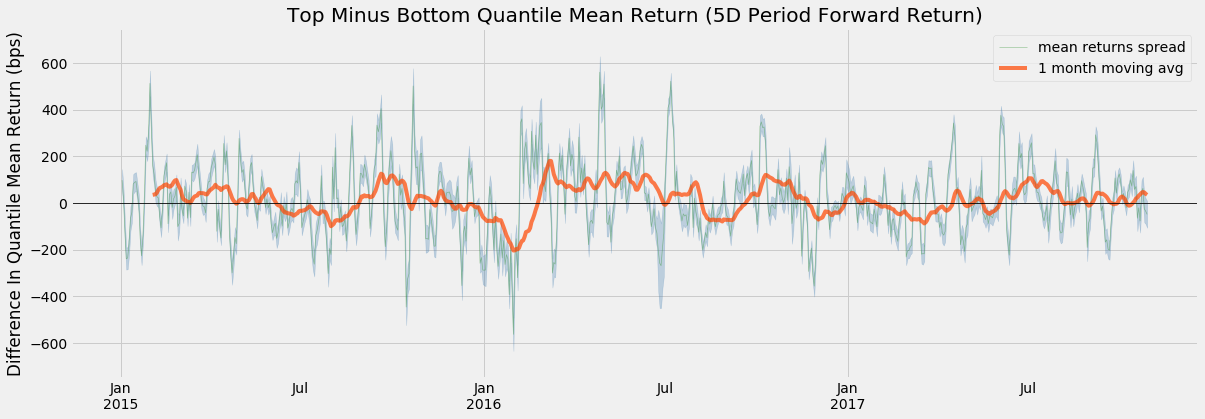

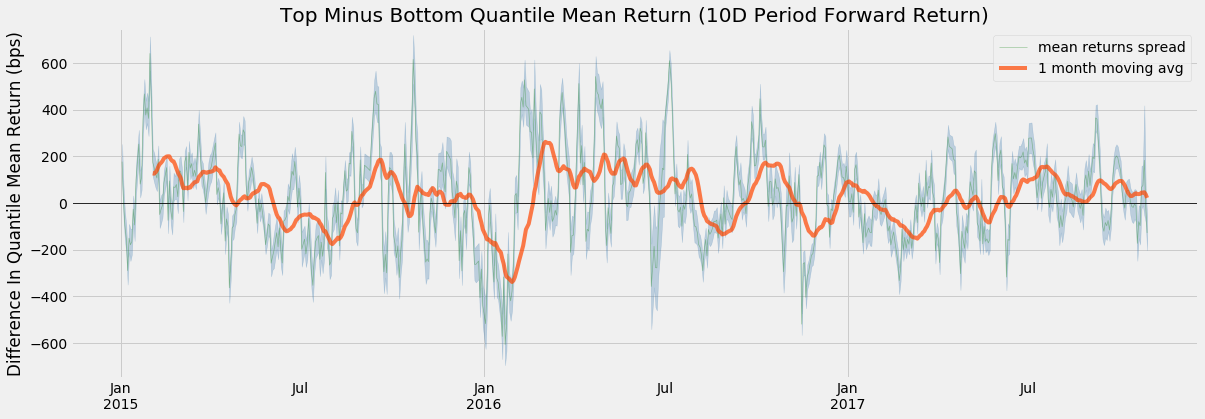

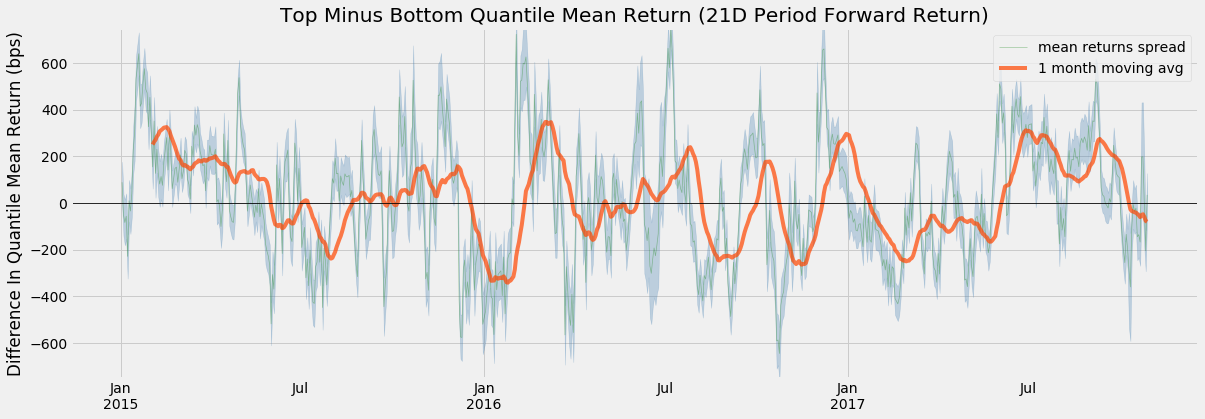

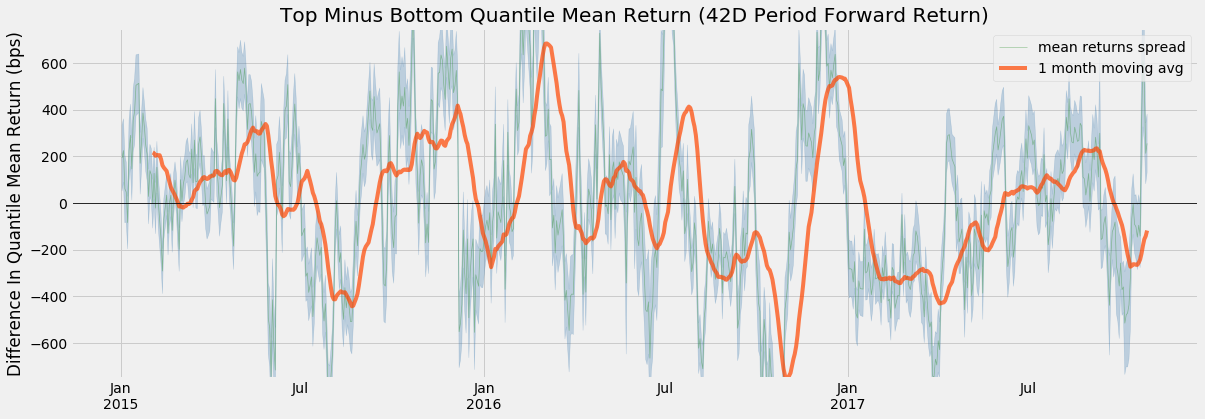

In [32]:
plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread);

By looking at the cumulative returns by factor quantile we can get an intuition for which quantiles are contributing the most to the factor and at what time. Ideally we would like to see a these curves originate at the same value on the left and spread out like a fan as they move to the right through time, with the higher quantiles on the top.

#### Returns of a Portfolio weighted by Factor Values

`Alphalens` also omputes period wise returns for portfolio weighted by factor values, which implies short positions for negative momentum.

In [33]:
ls_factor_returns = factor_returns(alphalens_data)

In [34]:
ls_factor_returns.head()

5D       10D       21D       42D
date                                                             
2015-01-02 00:00:00+00:00  0.003387  0.006297  0.002120  0.008516
2015-01-05 00:00:00+00:00  0.000912  0.001371 -0.002146  0.009167
2015-01-06 00:00:00+00:00 -0.003566 -0.002036 -0.003732  0.006086
2015-01-07 00:00:00+00:00 -0.008689 -0.005023 -0.002133  0.007138
2015-01-08 00:00:00+00:00 -0.008520 -0.009555 -0.007879  0.003595

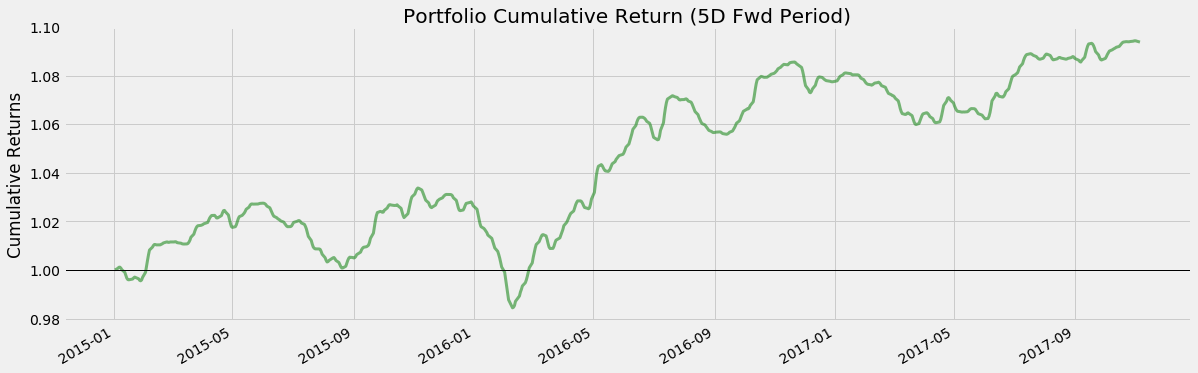

In [35]:
plot_cumulative_returns(ls_factor_returns['5D'], period='5D');

In [36]:
alpha_beta = factor_alpha_beta(alphalens_data, returns=benchmark.fillna(0))

In [37]:
alpha_beta

5D       10D       21D       42D
Ann. alpha  0.005154  0.011554  0.024265  0.026351
beta        0.506189  0.517531  0.495346  0.509282

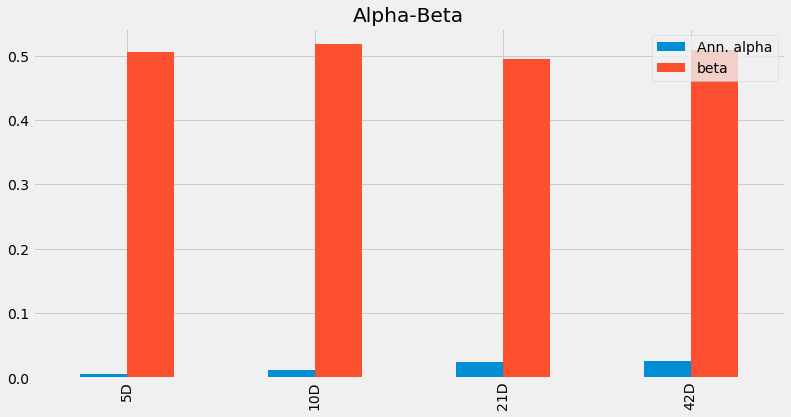

In [38]:
alpha_beta.T.plot.bar(title='Alpha-Beta', figsize=(12,6));

### Returns Tear Sheet

We can view all returns analysis calculations together.

Returns Analysis


5D     10D    21D    42D
Ann. alpha                                      0.026   0.024  0.006 -0.002
beta                                            0.075   0.070  0.065  0.028
Mean Period Wise Return Top Quantile (bps)      4.137   5.096  2.525 -0.958
Mean Period Wise Return Bottom Quantile (bps) -10.003  -7.856 -2.894 -1.346
Mean Period Wise Spread (bps)                  14.029  12.872  5.359  0.319

<Figure size 432x288 with 0 Axes>

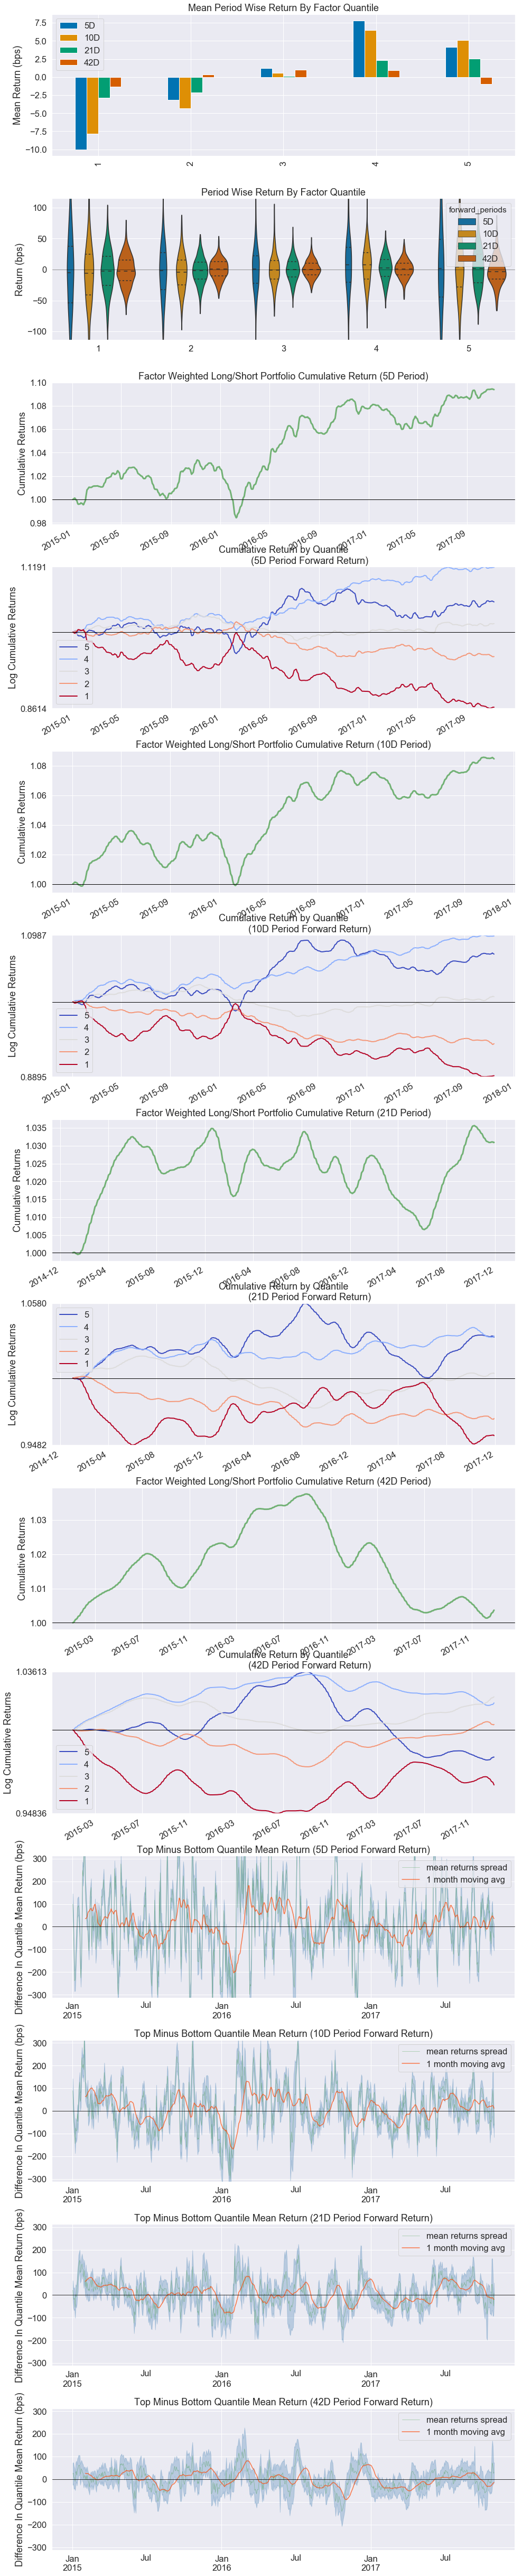

In [39]:
create_returns_tear_sheet(alphalens_data)

## Information Analysis

Information Analysis is a way for us to evaluate the predicitive value of a factor without the confounding effects of transaction costs. The main way we look at this is through the Information Coefficient (IC).

From Wikipedia...

>The information coefficient (IC) is a measure of the merit of a predicted value. In finance, the information coefficient is used as a performance metric for the predictive skill of a financial analyst. The information coefficient is similar to correlation in that it can be seen to measure the linear relationship between two random variables, e.g. predicted stock returns and the actualized returns. The information coefficient ranges from 0 to 1, with 0 denoting no linear relationship between predictions and actual values (poor forecasting skills) and 1 denoting a perfect linear relationship (good forecasting skills).

In [40]:
ic = factor_information_coefficient(alphalens_data)

In [41]:
ic.head()

5D       10D       21D       42D
date                                                             
2015-01-02 00:00:00+00:00  0.078643  0.097991  0.056166  0.066873
2015-01-05 00:00:00+00:00  0.005779  0.003576  0.007799  0.079777
2015-01-06 00:00:00+00:00 -0.088589 -0.039456  0.006445  0.047075
2015-01-07 00:00:00+00:00 -0.224003 -0.092155  0.034840  0.064681
2015-01-08 00:00:00+00:00 -0.188663 -0.178050 -0.030116  0.035869

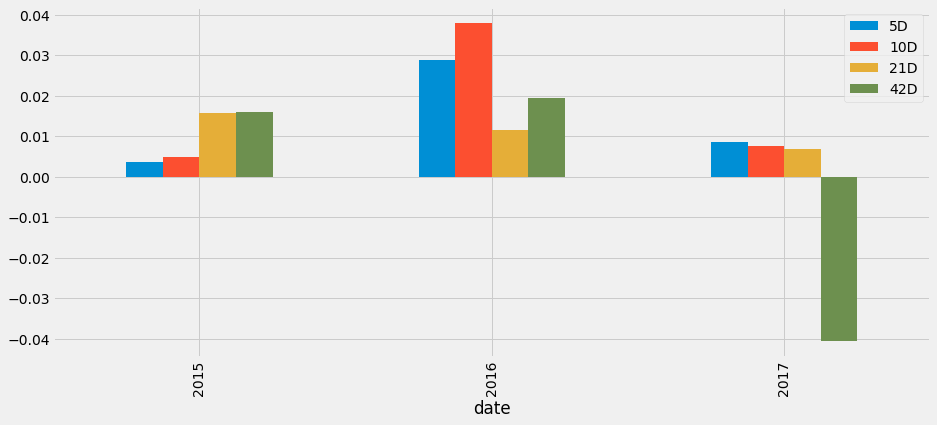

In [42]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))

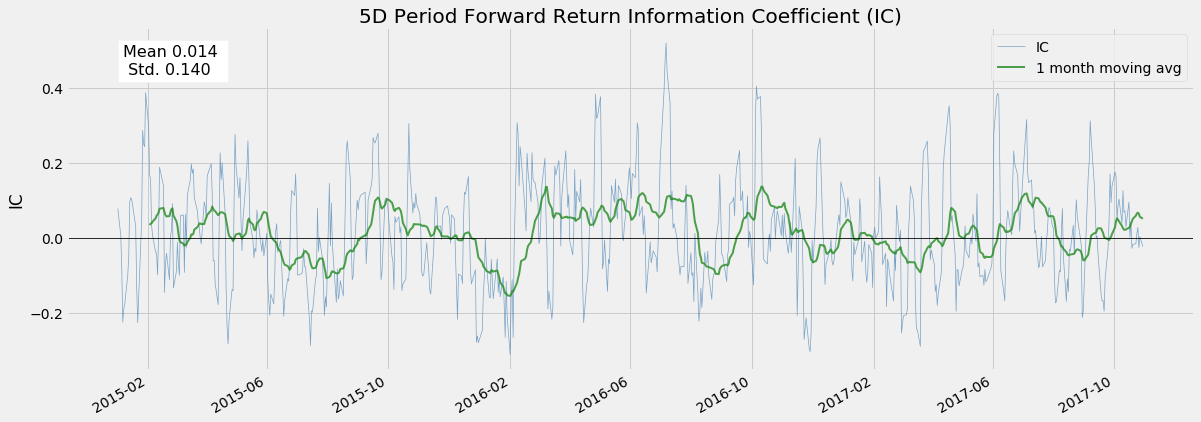

In [43]:
plot_ic_ts(ic[['5D']]);

By looking at the IC each day we can understand how theoretically predicitive our factor is overtime. We like our mean IC to be high and the standard deviation, or volatility of it, to be low. We want to find consistently predictive factors.

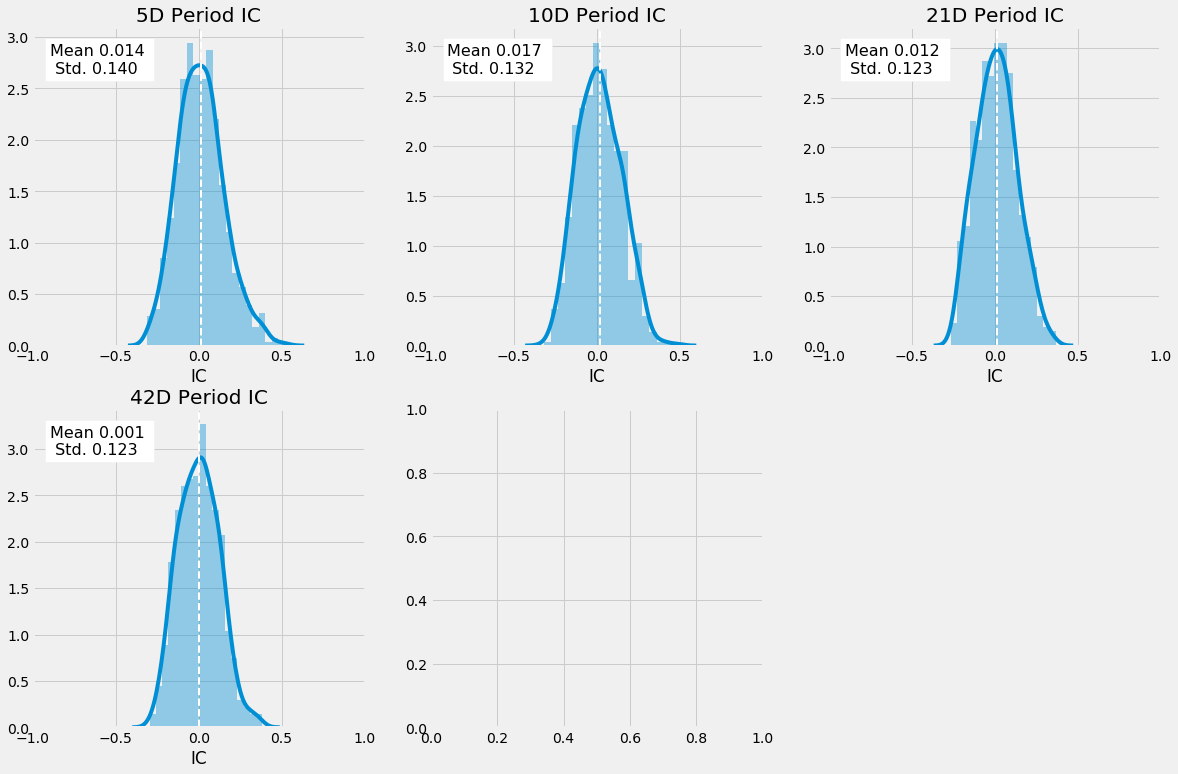

In [44]:
plot_ic_hist(ic);

Looking at a histogram of the daily IC values can indicate how the factor behaves most of the time, where the likely IC values will fall, it also allows us to see if the factor has fat tails.

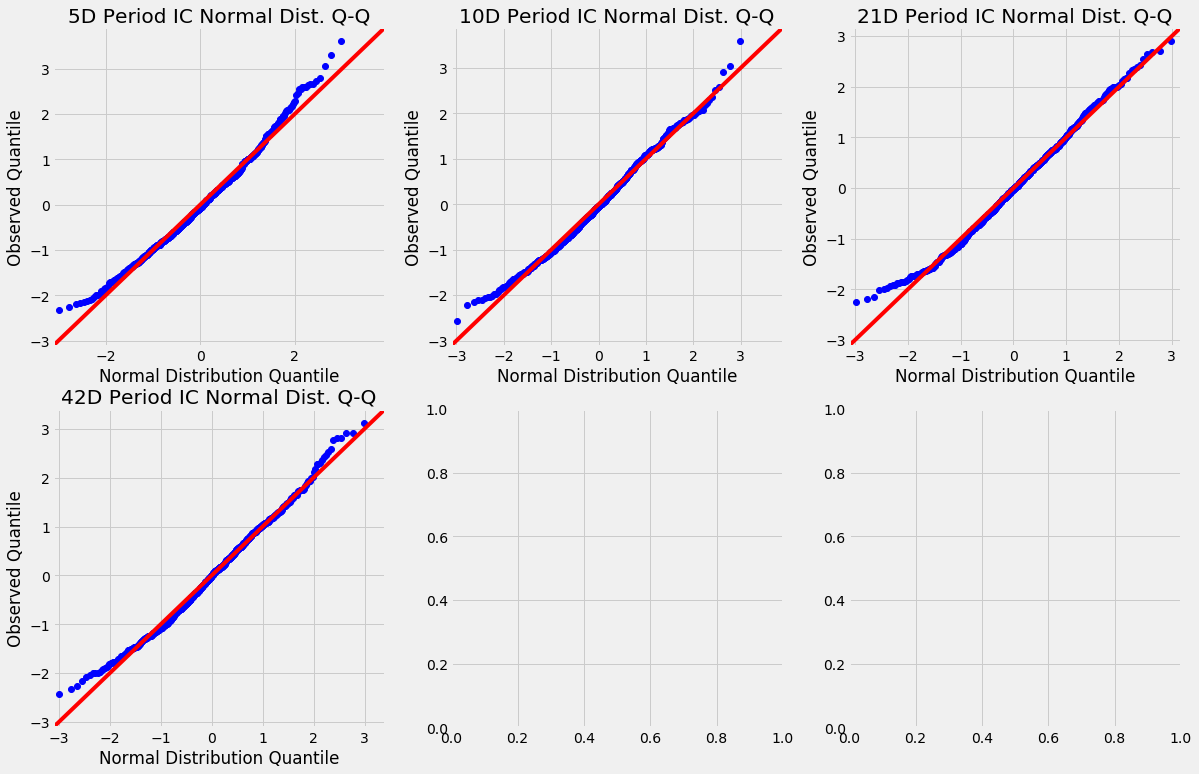

In [45]:
plot_ic_qq(ic);

These Q-Q plots show the difference in shape between the distribution of IC values and a normal distribution. This is especially helpful in seeing how the most extreme values in the distribution affect the predicitive power.

In [46]:
mean_monthly_ic = mean_information_coefficient(alphalens_data, by_time='M')

In [47]:
mean_monthly_ic.head()

5D       10D       21D       42D
date                                                             
2015-01-31 00:00:00+00:00  0.014916  0.066504  0.130620  0.104261
2015-02-28 00:00:00+00:00  0.023210  0.023535  0.058704 -0.046133
2015-03-31 00:00:00+00:00  0.047286  0.097436  0.100489  0.044273
2015-04-30 00:00:00+00:00  0.001018 -0.009274  0.040470  0.047866
2015-05-31 00:00:00+00:00  0.058599  0.036547 -0.034195  0.048716

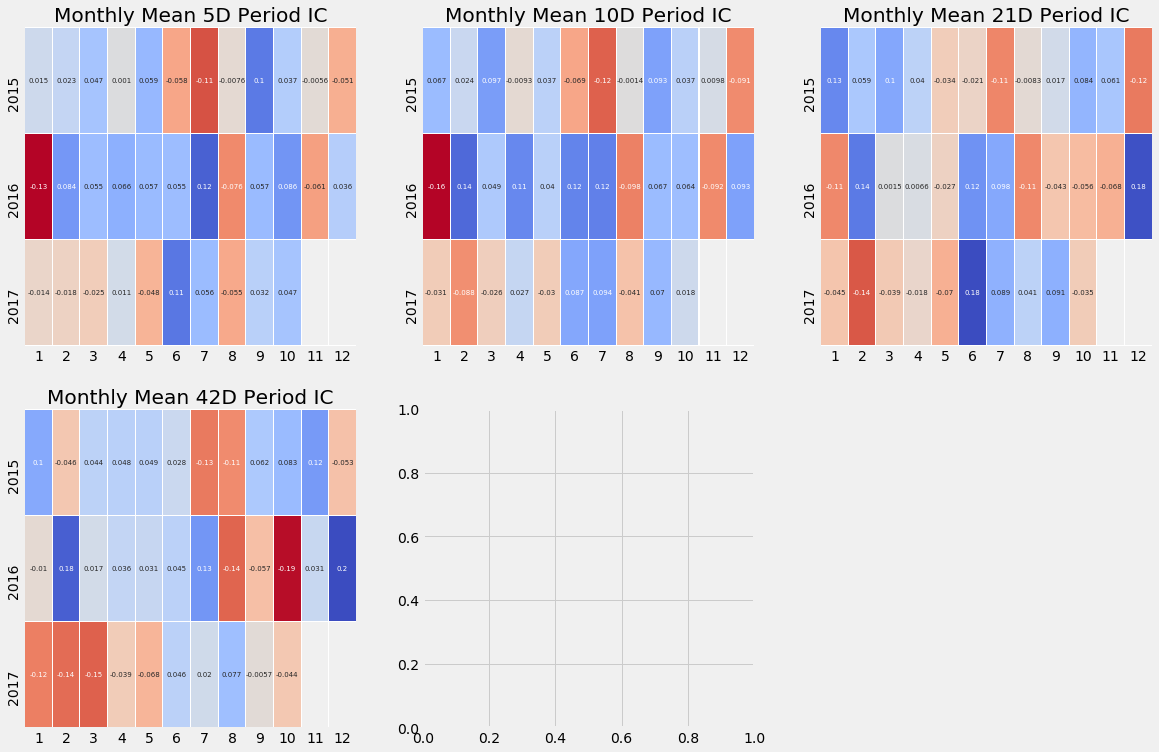

In [48]:
plot_monthly_ic_heatmap(mean_monthly_ic);

### Information Tear Sheet

We can view all information analysis calculations together.

Information Analysis


5D    10D    21D    42D
IC Mean           0.014  0.017  0.012  0.001
IC Std.           0.140  0.132  0.123  0.123
Risk-Adjusted IC  0.100  0.132  0.095  0.005
t-stat(IC)        2.678  3.527  2.529  0.144
p-value(IC)       0.008  0.000  0.012  0.886
IC Skew           0.411  0.224  0.192  0.209
IC Kurtosis       0.182 -0.330 -0.423 -0.265

<Figure size 432x288 with 0 Axes>

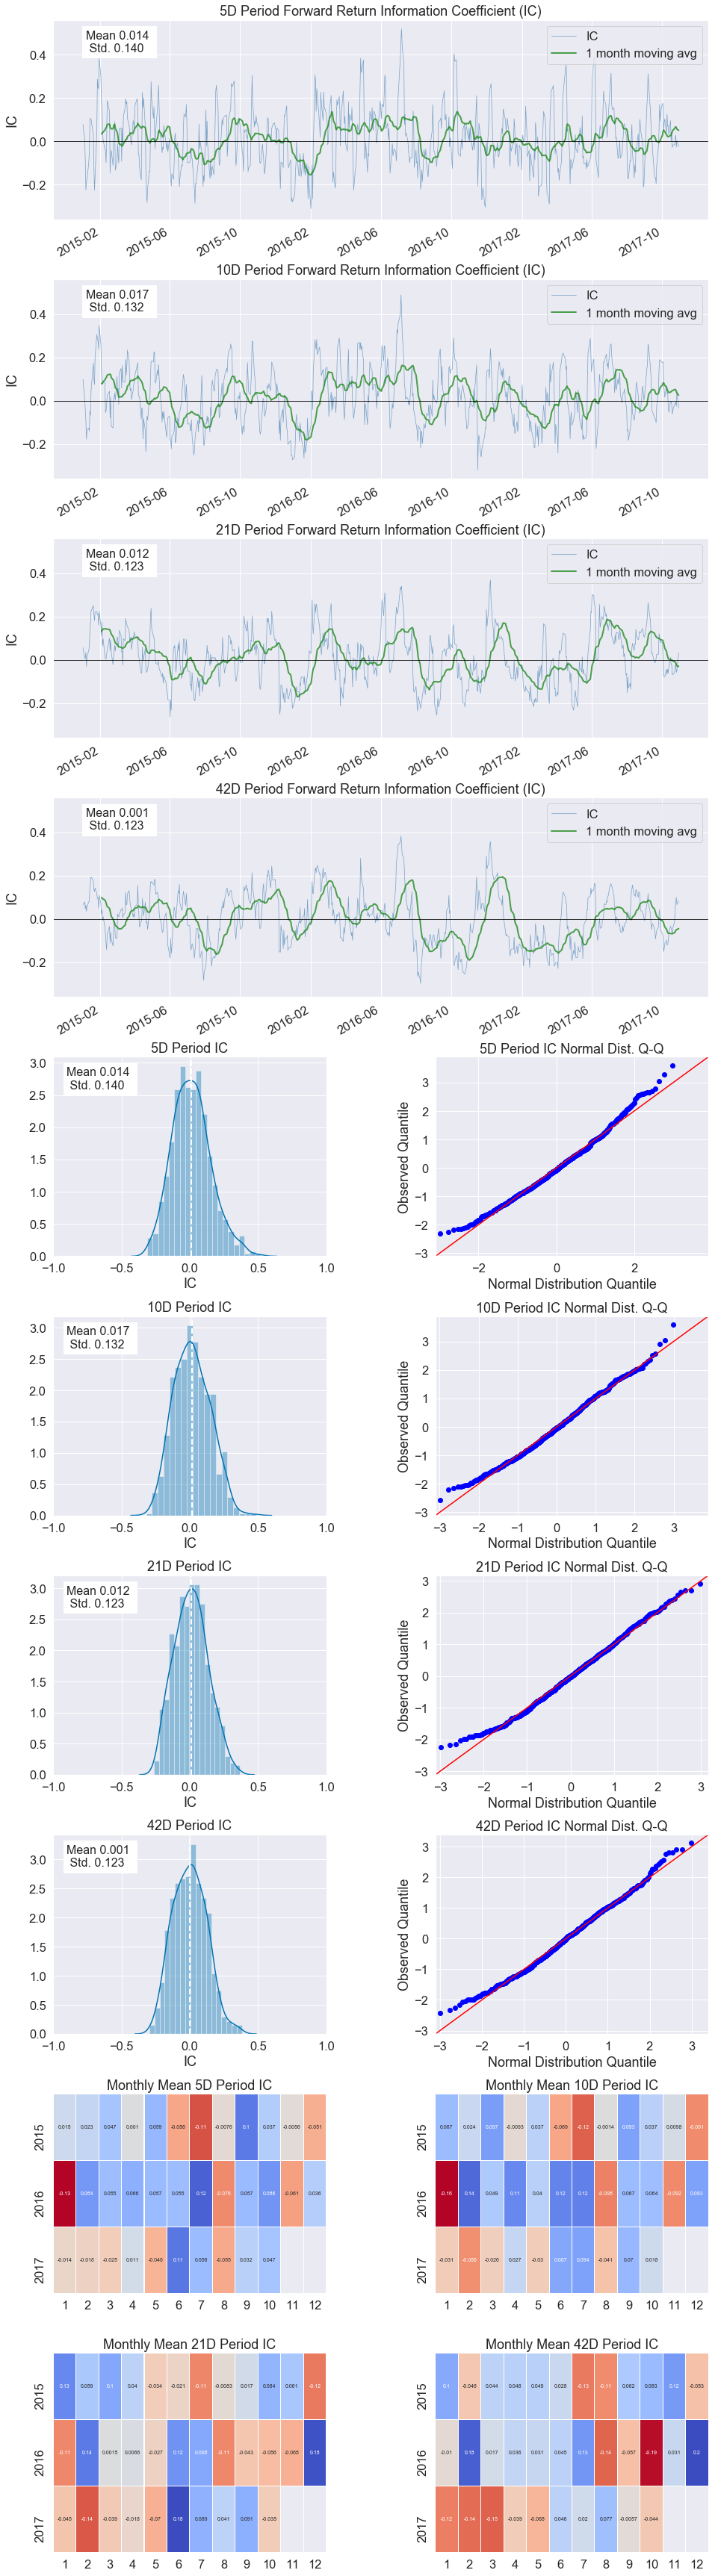

In [49]:
create_information_tear_sheet(alphalens_data)

## Turnover Analysis

Turnover Analysis gives us an idea about the nature of a factor's makeup and how it changes.

In [81]:
quantile_factor = alphalens_data['factor_quantile']
turnover_period = '5D'

In [82]:
quantile_turnover = pd.concat([quantile_turnover(quantile_factor, q, turnover_period)
                               for q in quantile_factor.unique()], axis=1)

TypeError: 'DataFrame' object is not callable

In [78]:
quantile_turnover.mean()

4    0.642080
2    0.645655
1    0.409680
5    0.394224
3    0.680674
dtype: float64

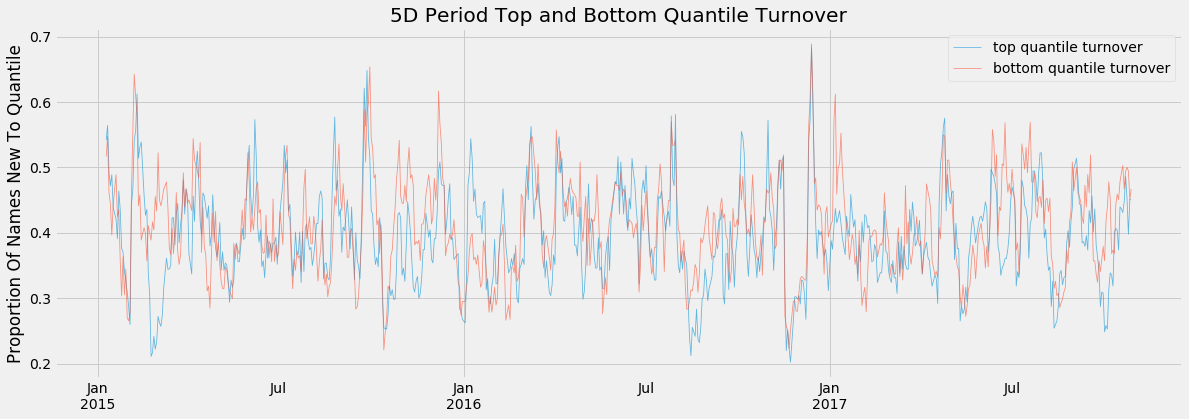

In [53]:
plot_top_bottom_quantile_turnover(quantile_turnover, turnover_period);

Factor turnover is important as it indicates the incorporation of new information and the make up of the extremes of a signal. By looking at the new additions to the sets of top and bottom quantiles we can see how much of this factor is getting remade everyday.

In [54]:
factor_autocorrelation = factor_rank_autocorrelation(alphalens_data, turnover_period)

In [55]:
factor_autocorrelation.head()

date
2015-01-02 00:00:00+00:00   NaN
2015-01-05 00:00:00+00:00   NaN
2015-01-06 00:00:00+00:00   NaN
2015-01-07 00:00:00+00:00   NaN
2015-01-08 00:00:00+00:00   NaN
Name: 5D, dtype: float64

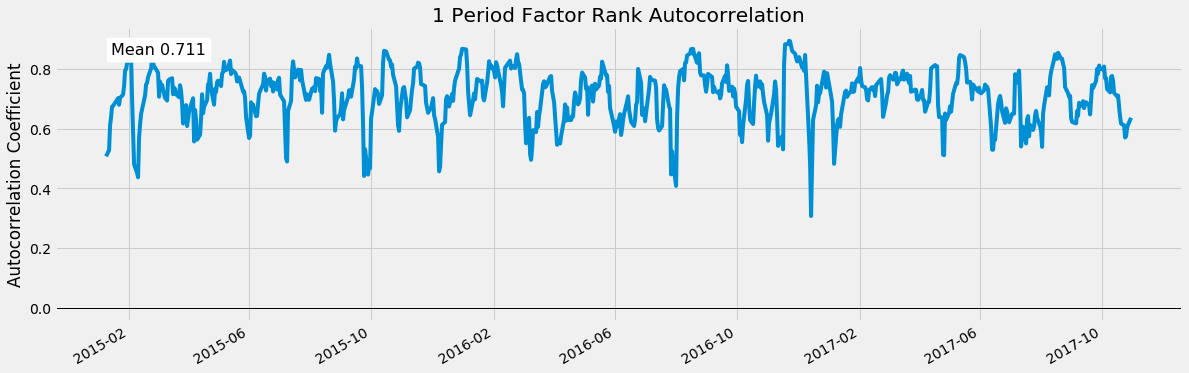

In [56]:
plot_factor_rank_auto_correlation(factor_autocorrelation);

The autocorrelation of the factor indicates to us the persistence of the signal itself.

### Turnover Tear Sheet

We can view all turnover calculations together.

Turnover Analysis


10D    21D    42D     5D
Quantile 1 Mean Turnover   0.588  0.832  0.828  0.410
Quantile 2 Mean Turnover   0.741  0.801  0.810  0.646
Quantile 3 Mean Turnover   0.762  0.804  0.807  0.681
Quantile 4 Mean Turnover   0.739  0.806  0.808  0.642
Quantile 5 Mean Turnover   0.568  0.811  0.806  0.394

5D    10D    21D    42D
Mean Factor Rank Autocorrelation  0.711  0.452 -0.031 -0.013

<Figure size 432x288 with 0 Axes>

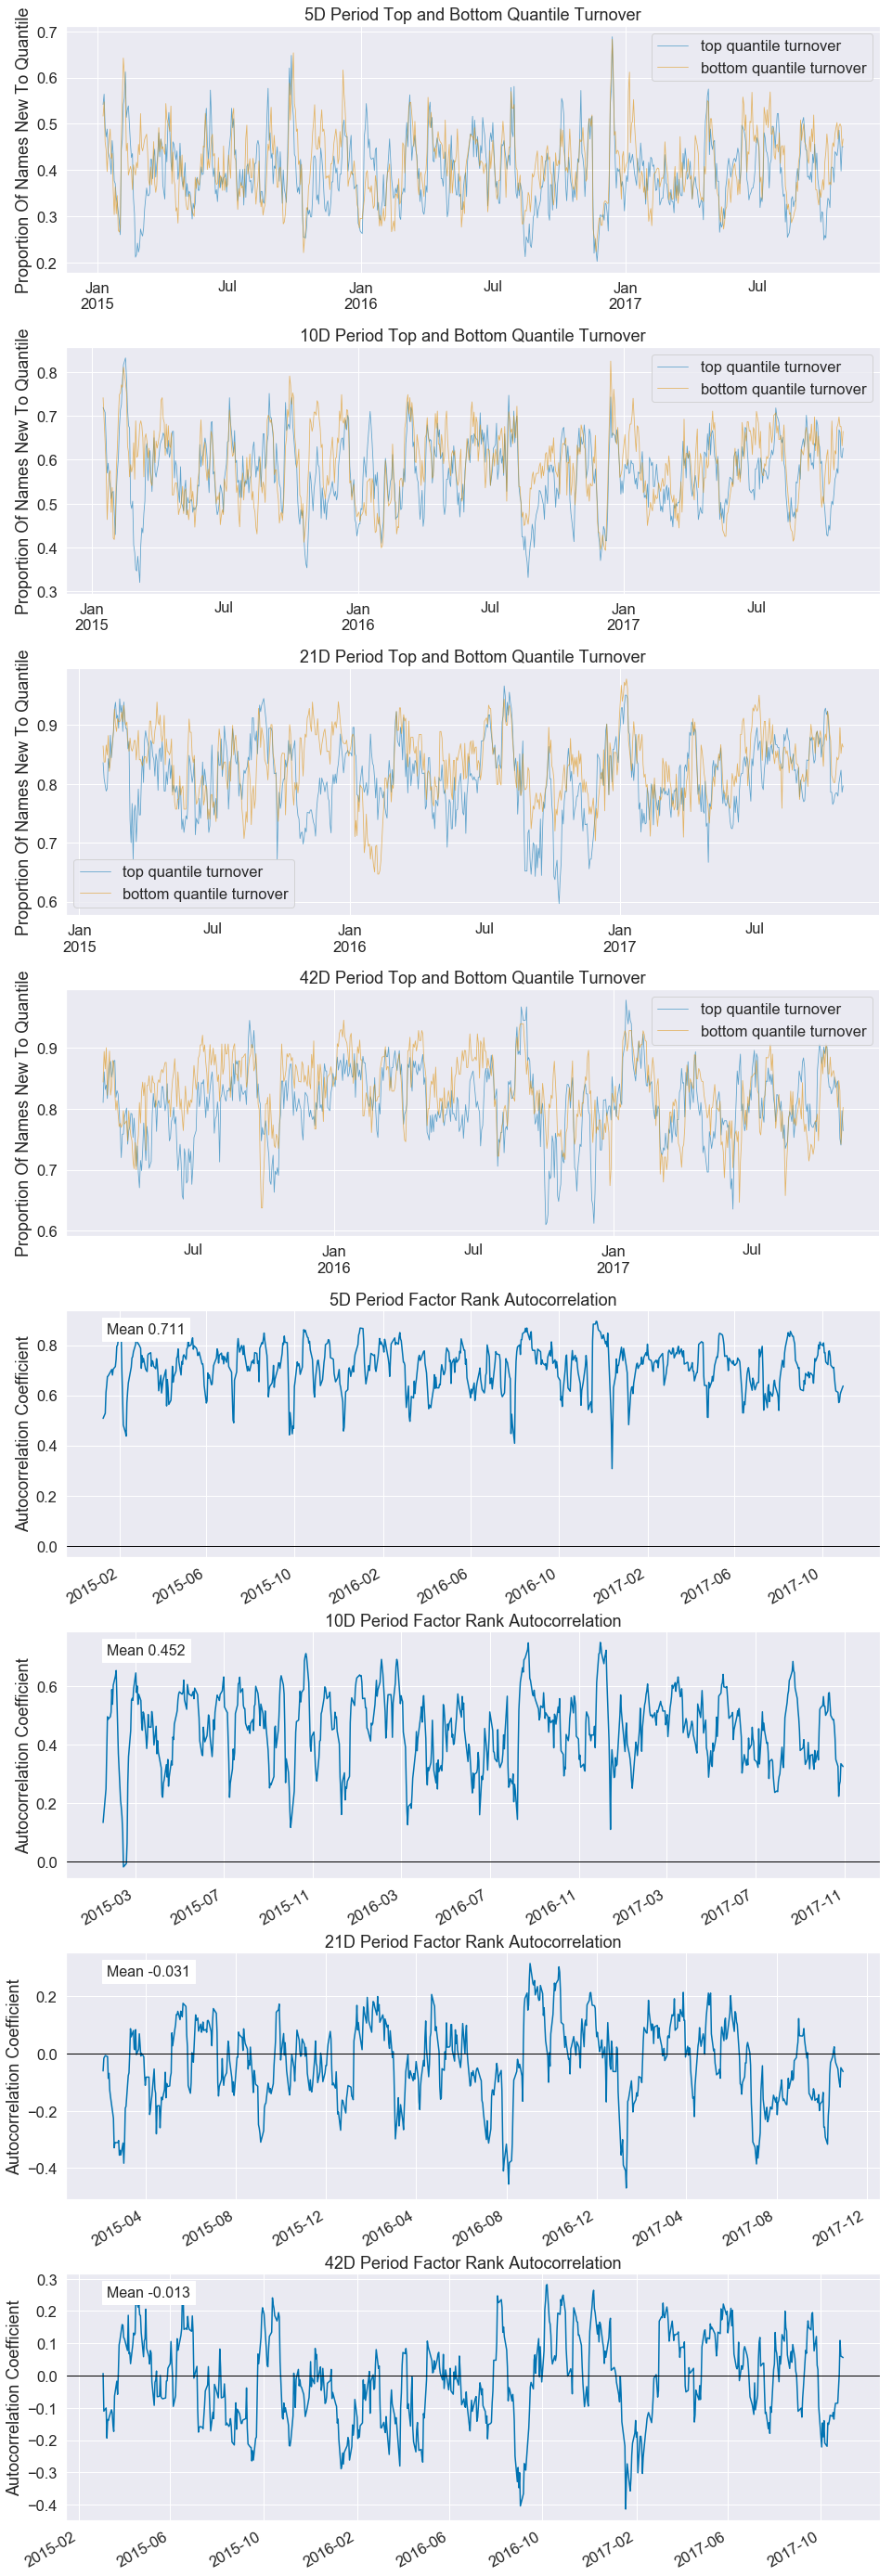

In [79]:
create_turnover_tear_sheet(alphalens_data)

## Event Style Returns Analysis

Looking at the average cumulative return in a window before and after a factor can indicate to us how long the predicative power of a factor lasts. This tear sheet takes a while to run.

**NOTE:** This tear sheet takes in an extra argument `pricing`.

In [58]:
# alphalens.tears.create_event_returns_tear_sheet(factor_data, pricing, by_group=True)

## Evaluation by Industry Sector

Many of the plots in Alphalens can be viewed on their own by grouping if grouping information is provided. The returns and information tear sheets can be viewed groupwise by passing in the `by_group=True` argument.

In [59]:
ic_by_sector = mean_information_coefficient(alphalens_data, by_group=True)

In [60]:
ic_by_sector.head()

5D       10D       21D       42D
group                                                        
Basic Industries       0.003362  0.008641  0.007282 -0.003153
Capital Goods          0.019882  0.014616  0.001875  0.015598
Consumer Durables     -0.001876 -0.007271  0.004767  0.026751
Consumer Non-Durables -0.004960 -0.002239 -0.007336 -0.003369
Consumer Services     -0.005051 -0.008045 -0.009763 -0.022872

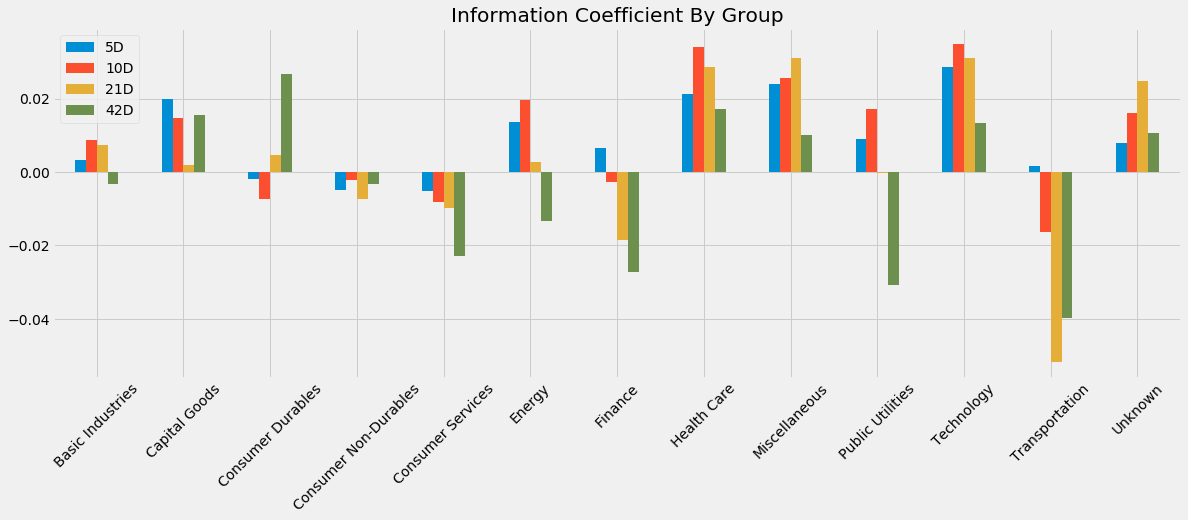

In [61]:
plot_ic_by_group(ic_by_sector);

In [62]:
mean_return_quantile_sector, mean_return_quantile_sector_err = mean_return_by_quantile(alphalens_data, by_group=True)

In [63]:
mean_return_quantile_sector.head()

5D       10D       21D       42D
factor_quantile group                                                        
1               Basic Industries       0.000460 -0.000427 -0.000404 -0.001875
                Capital Goods         -0.000360  0.000320  0.003178  0.005662
                Consumer Durables     -0.000162 -0.000420 -0.000142 -0.007985
                Consumer Non-Durables -0.001386 -0.003737 -0.005183 -0.007225
                Consumer Services     -0.000938 -0.001423 -0.003483 -0.007290

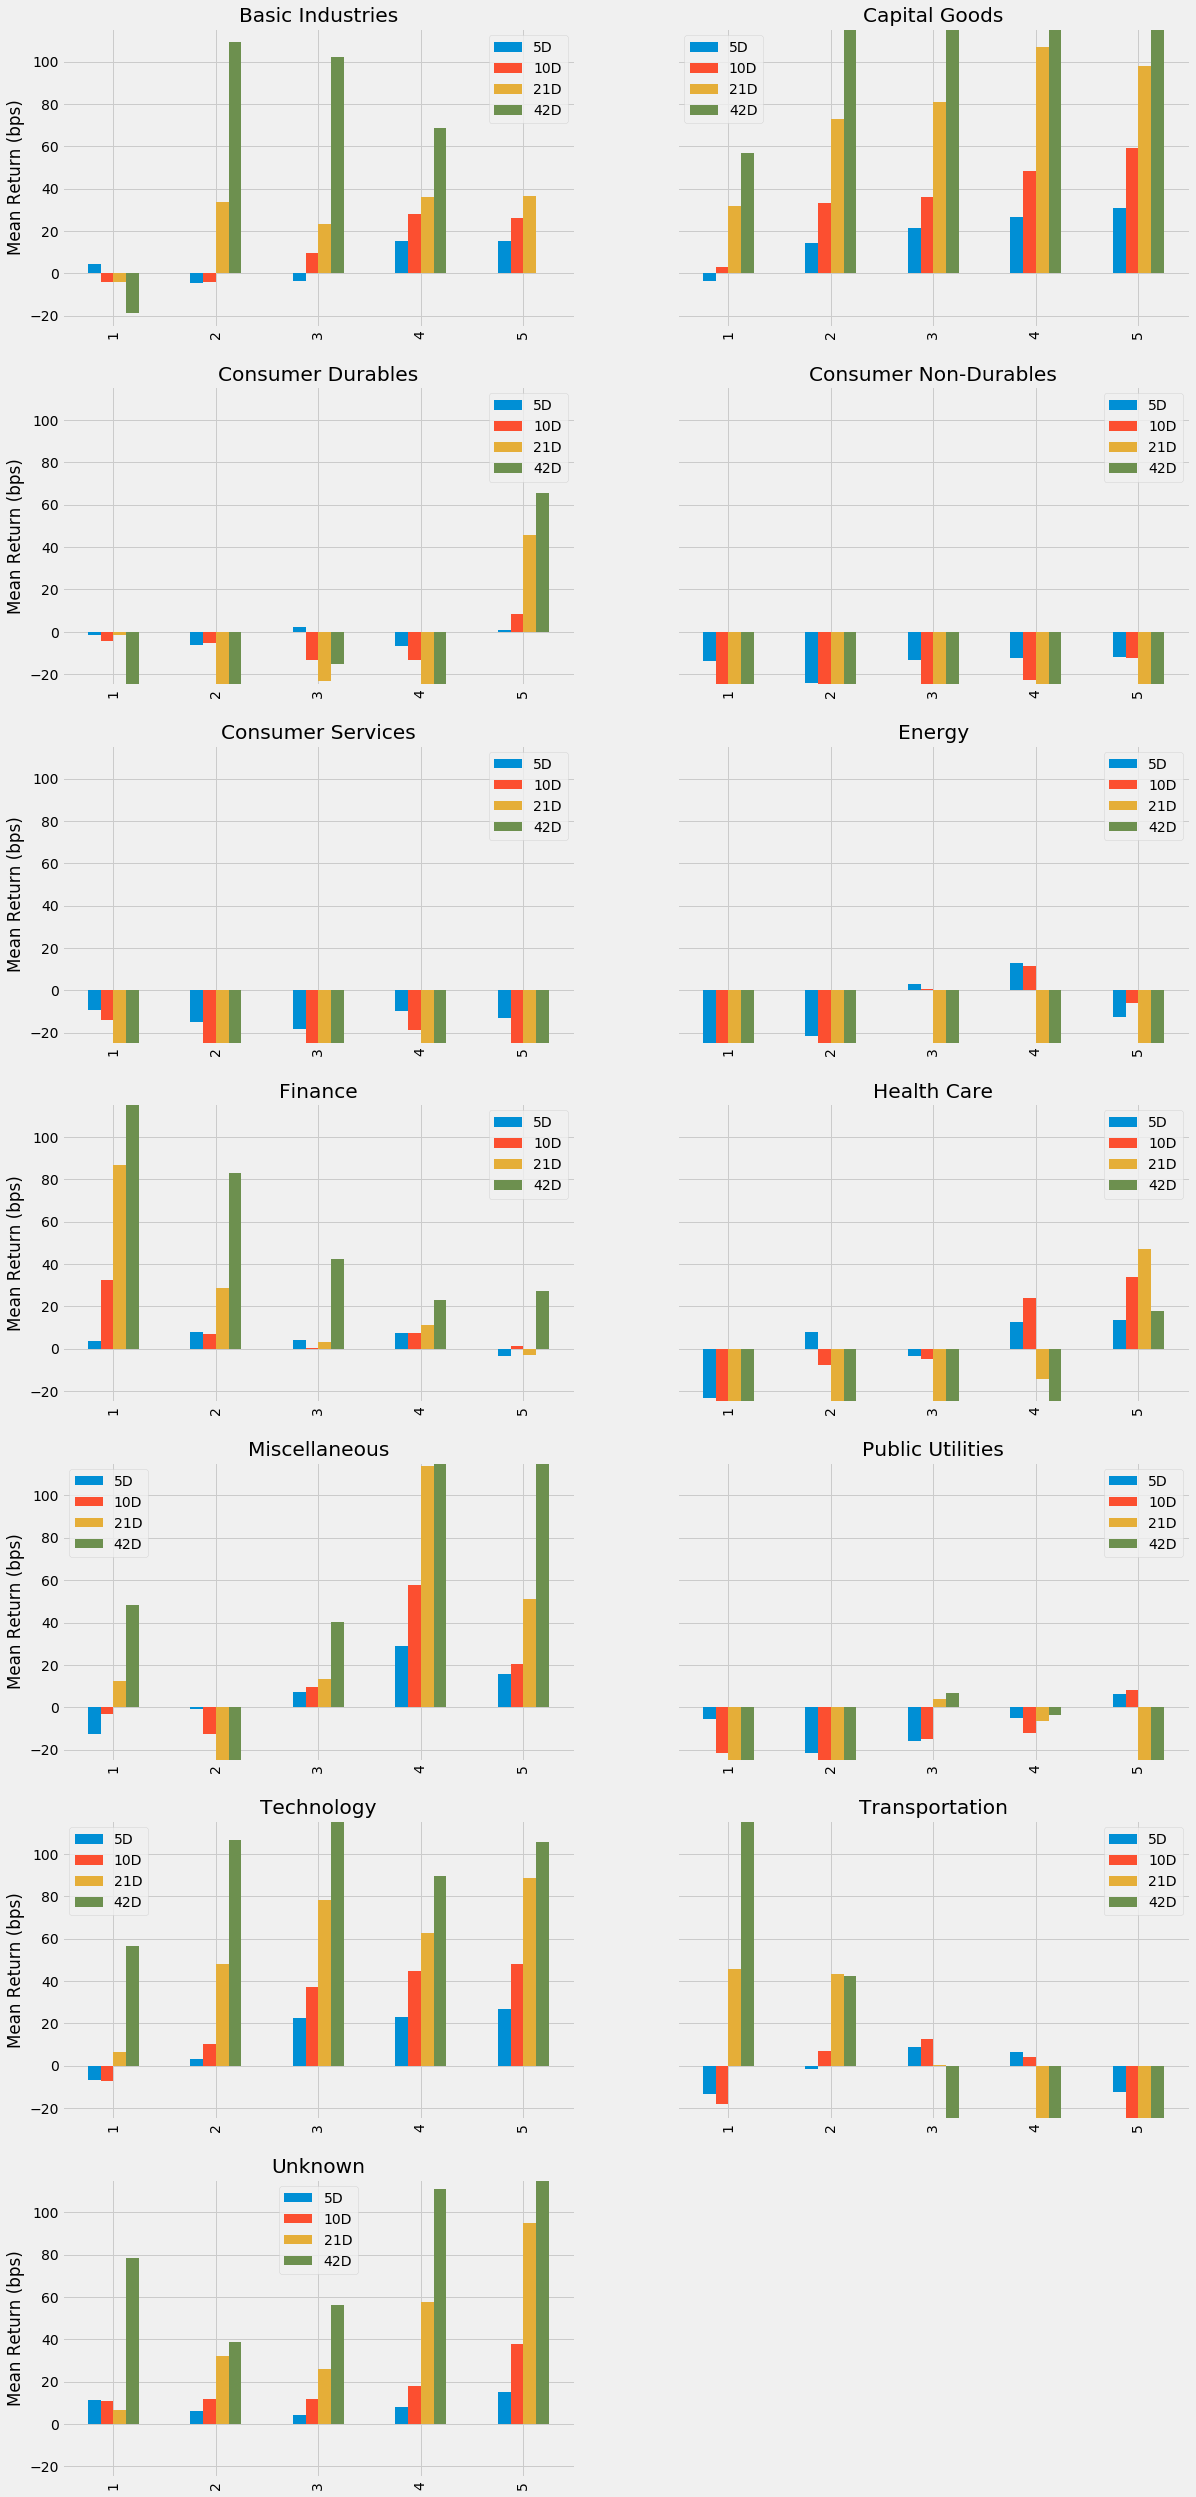

In [64]:
plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

# The Whole Thing

If you want to see all of the results create a full tear sheet. By passing in the factor data you can analyze all of the above statistics and plots at once.

Quantiles Statistics


min     max         mean         std   count    count %
factor_quantile                                                            
1                   1.0  1115.0   301.980136  187.992483  128875  20.044701
2                 337.0  1782.0   843.855418  241.218338  128446  19.977976
3                 743.0  2306.0  1400.251818  271.991154  128446  19.977976
4                1204.0  2719.0  1962.969941  263.516180  128446  19.977976
5                1760.0  3056.0  2508.149715  231.925464  128725  20.021371

Returns Analysis


5D     10D    21D    42D
Ann. alpha                                      0.026   0.024  0.006 -0.002
beta                                            0.075   0.070  0.065  0.028
Mean Period Wise Return Top Quantile (bps)      4.137   5.096  2.525 -0.958
Mean Period Wise Return Bottom Quantile (bps) -10.003  -7.856 -2.894 -1.346
Mean Period Wise Spread (bps)                  14.029  12.872  5.359  0.319

<Figure size 432x288 with 0 Axes>

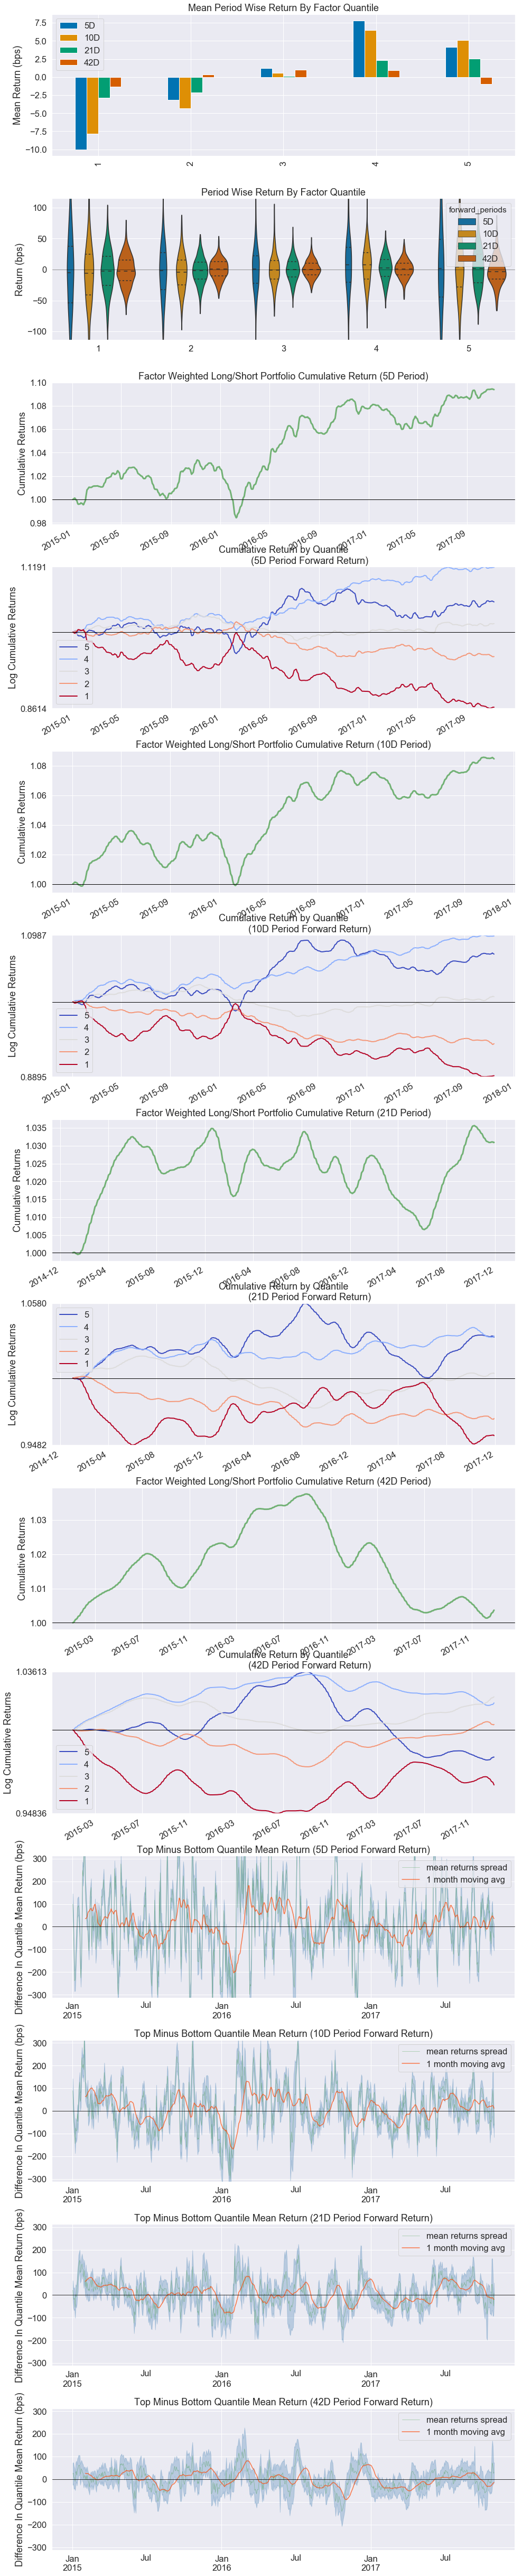

Information Analysis


5D    10D    21D    42D
IC Mean           0.014  0.017  0.012  0.001
IC Std.           0.140  0.132  0.123  0.123
Risk-Adjusted IC  0.100  0.132  0.095  0.005
t-stat(IC)        2.678  3.527  2.529  0.144
p-value(IC)       0.008  0.000  0.012  0.886
IC Skew           0.411  0.224  0.192  0.209
IC Kurtosis       0.182 -0.330 -0.423 -0.265

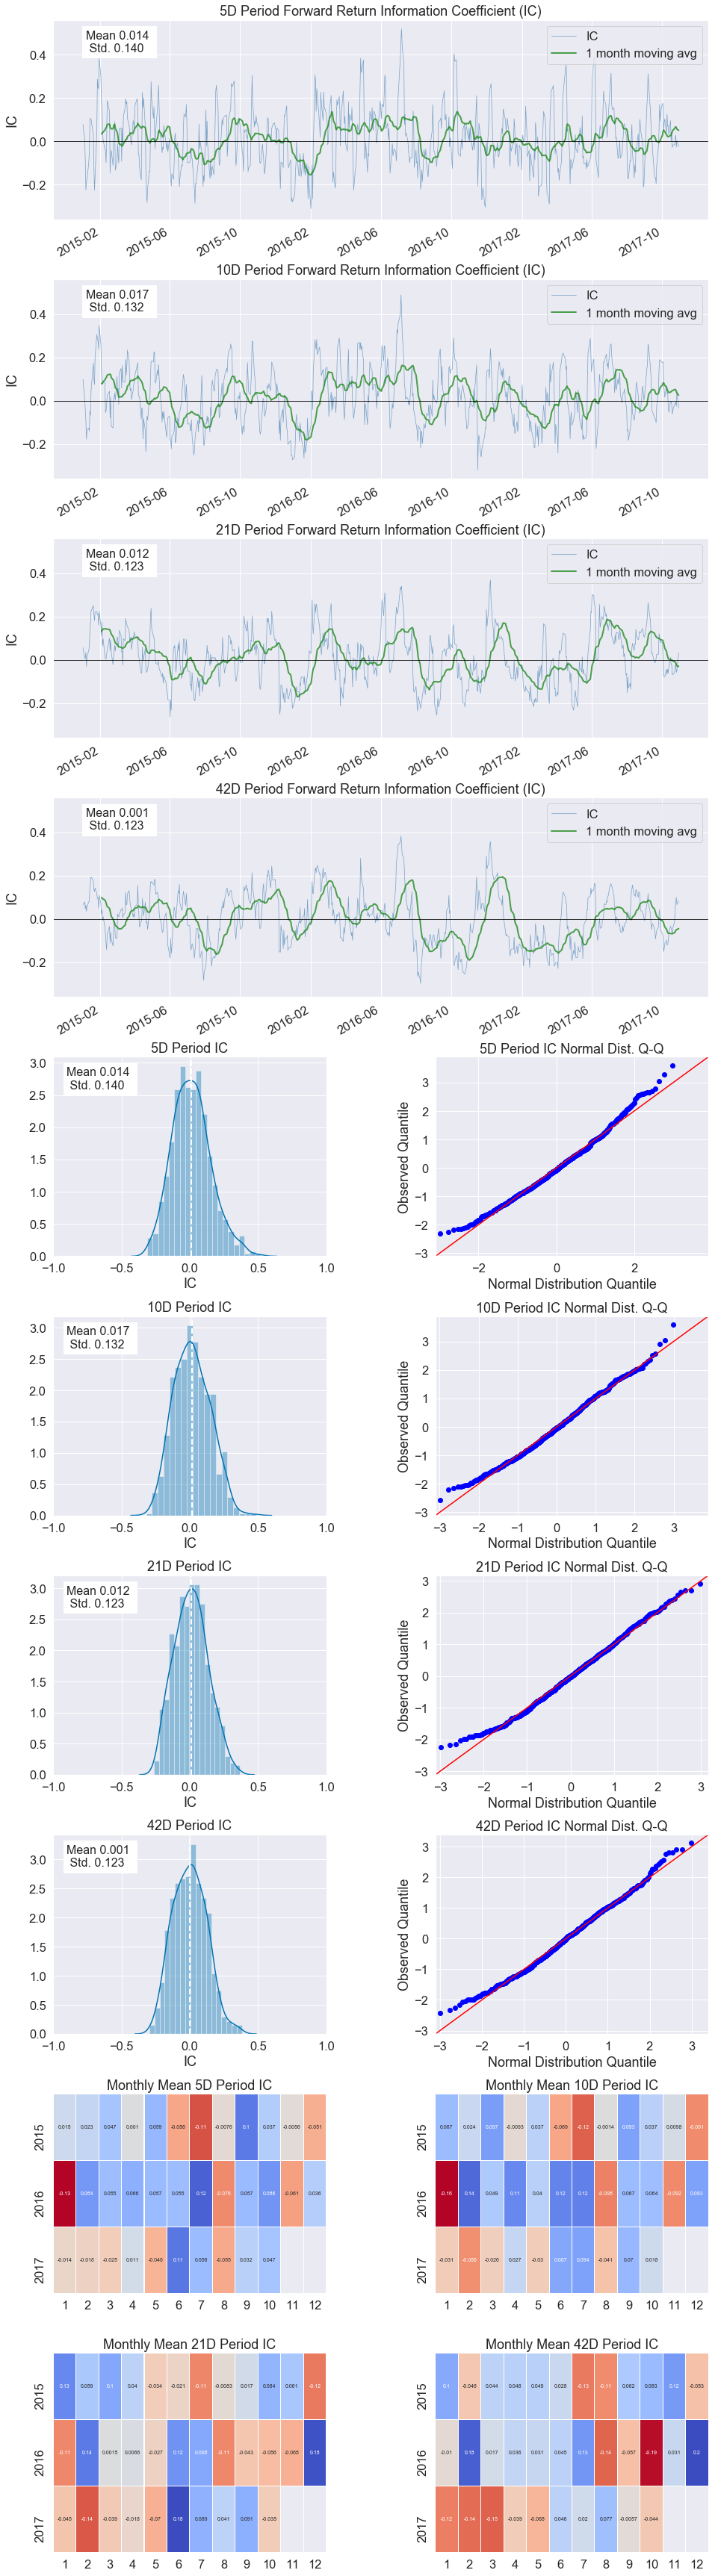

Turnover Analysis


10D    21D    42D     5D
Quantile 1 Mean Turnover   0.588  0.832  0.828  0.410
Quantile 2 Mean Turnover   0.741  0.801  0.810  0.646
Quantile 3 Mean Turnover   0.762  0.804  0.807  0.681
Quantile 4 Mean Turnover   0.739  0.806  0.808  0.642
Quantile 5 Mean Turnover   0.568  0.811  0.806  0.394

5D    10D    21D    42D
Mean Factor Rank Autocorrelation  0.711  0.452 -0.031 -0.013

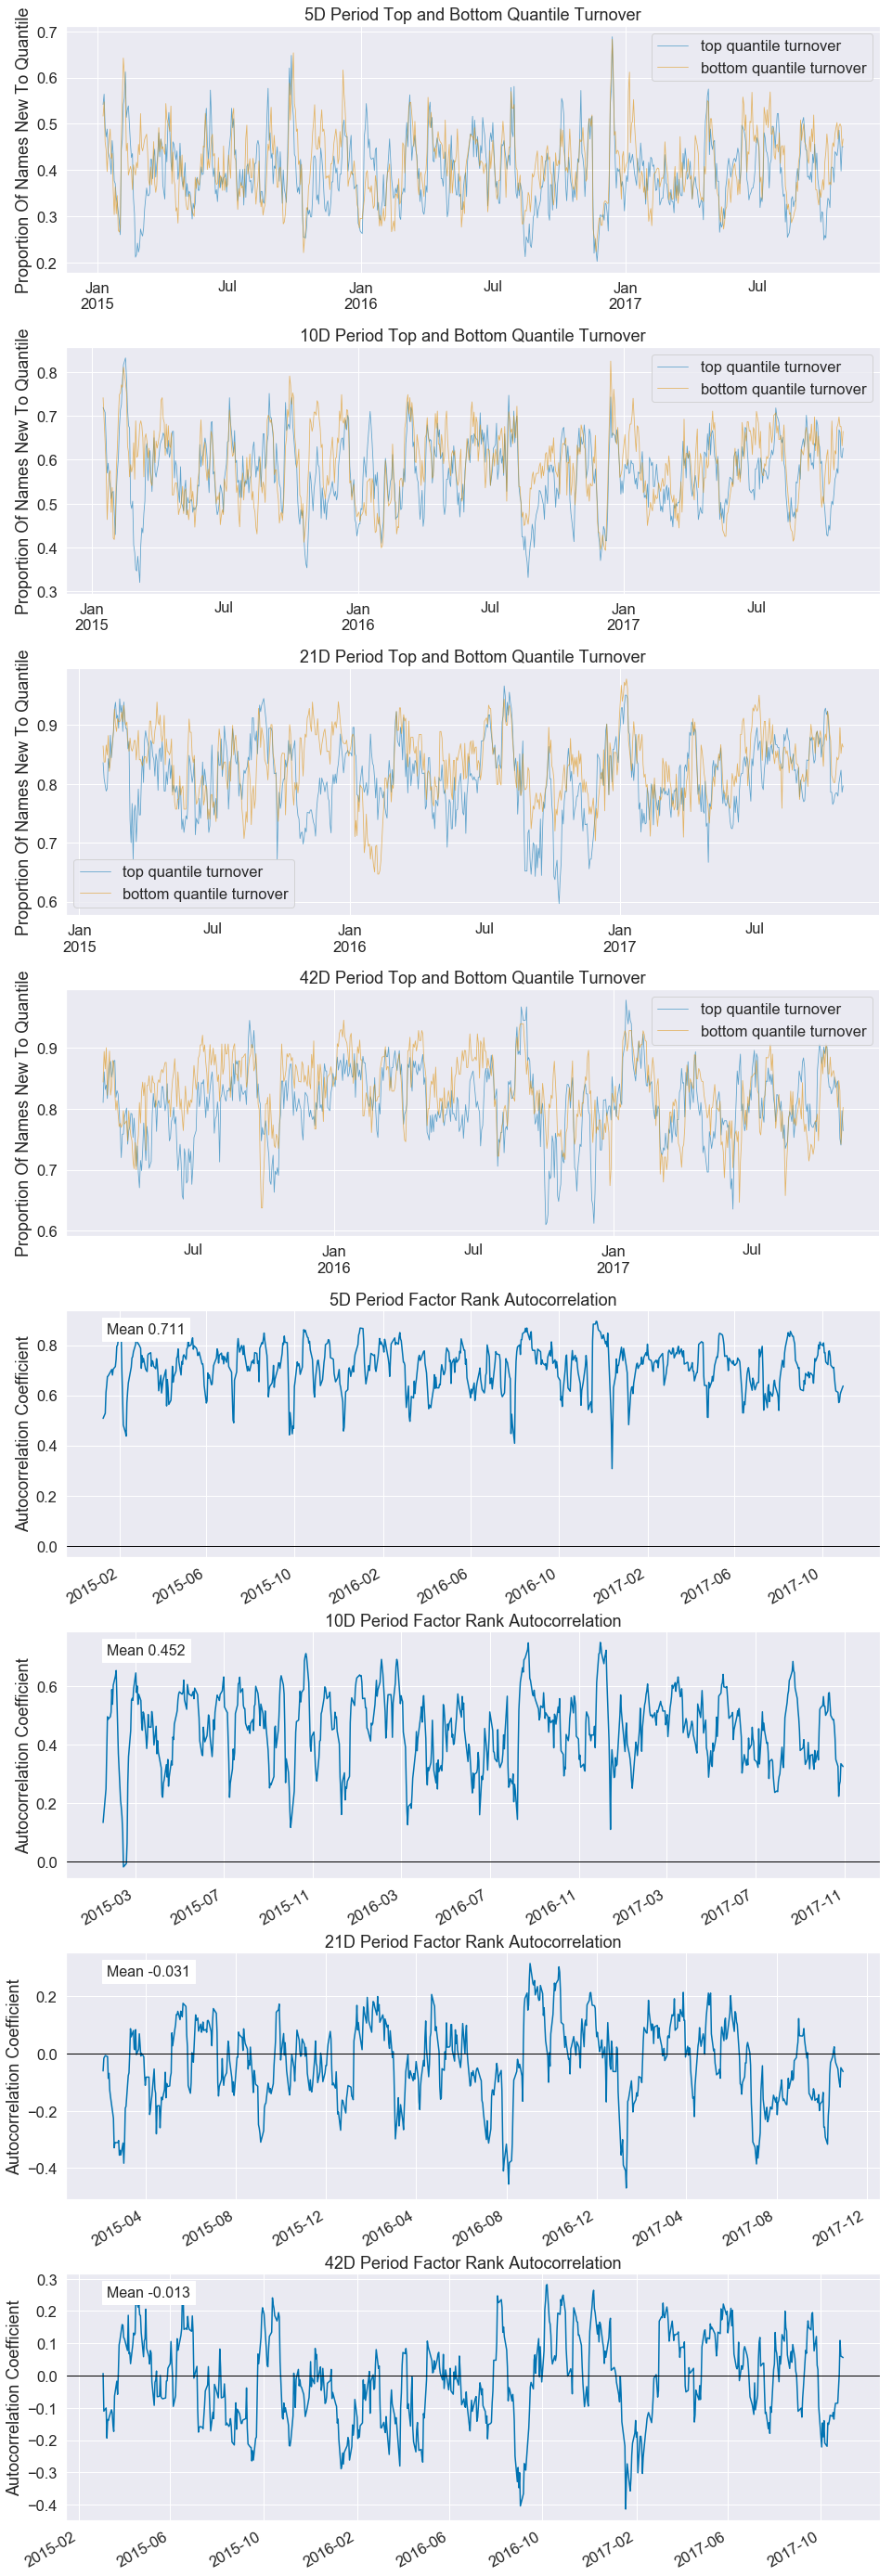

In [65]:
create_full_tear_sheet(alphalens_data)